In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers  import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Bidirectional,Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

The four algorithms used for this Assignment:

* Logistic Regression
* LSTM
* LSTM + CNN
* Fastext

# Data Preprocessing steps

In [4]:
# dataset
dataset2 = pd.read_csv('Dataset-2.csv')
dataset2.head()

,Title,Content,Domain
0,A Few Best Men (2011) - IMDb,A Few Best Men 2011 Not Rated 1h 37m IMDb RATI...,Entertainment
1,A Good Day to Die Hard (2013) - IMDb,A Good Day to Die Hard 2013 R 1h 38m IMDb RATI...,Entertainment
2,A Knight's Tale (2001) - IMDb,A Knights Tale 2001 PG13 2h 12m IMDb RATING 70...,Entertainment
3,Abraham Lincoln: Vampire Hunter (2012) - IMDb,Abraham Lincoln Vampire Hunter 2012 R 1h 45m I...,Entertainment
4,After the Sunset (2004) - IMDb,After the Sunset 2004 PG13 1h 37m IMDb RATING ...,Entertainment


In [5]:
# combining the textual features
dataset2['Texts'] = dataset2['Title'] +" "+ dataset2['Content']
dataset2.head()

,Title,Content,Domain,Texts
0,A Few Best Men (2011) - IMDb,A Few Best Men 2011 Not Rated 1h 37m IMDb RATI...,Entertainment,A Few Best Men (2011) - IMDb A Few Best Men 20...
1,A Good Day to Die Hard (2013) - IMDb,A Good Day to Die Hard 2013 R 1h 38m IMDb RATI...,Entertainment,A Good Day to Die Hard (2013) - IMDb A Good Da...
2,A Knight's Tale (2001) - IMDb,A Knights Tale 2001 PG13 2h 12m IMDb RATING 70...,Entertainment,A Knight's Tale (2001) - IMDb A Knights Tale 2...
3,Abraham Lincoln: Vampire Hunter (2012) - IMDb,Abraham Lincoln Vampire Hunter 2012 R 1h 45m I...,Entertainment,Abraham Lincoln: Vampire Hunter (2012) - IMDb ...
4,After the Sunset (2004) - IMDb,After the Sunset 2004 PG13 1h 37m IMDb RATING ...,Entertainment,After the Sunset (2004) - IMDb After the Sunse...


In [6]:
# converting the labels as one-hot-encoding
dataset2 = pd.get_dummies(dataset2, columns=["Domain"])
dataset2['Entertainment'] = dataset2["Domain_Entertainment"].astype(int)
dataset2['Healthcare'] = dataset2["Domain_Healthcare"].astype(int)
dataset2['Sports'] = dataset2["Domain_Sports"].astype(int)
dataset2['Technology'] = dataset2["Domain_Technology"].astype(int)
dataset2['Tourism'] = dataset2["Domain_Tourism"].astype(int)

dataset2=dataset2.drop(['Title','Content','Domain_Tourism','Domain_Technology','Domain_Sports','Domain_Healthcare','Domain_Entertainment'],axis=1)

dataset2

,Texts,Entertainment,Healthcare,Sports,Technology,Tourism
0,A Few Best Men (2011) - IMDb A Few Best Men 20...,1,0,0,0,0
1,A Good Day to Die Hard (2013) - IMDb A Good Da...,1,0,0,0,0
2,A Knight's Tale (2001) - IMDb A Knights Tale 2...,1,0,0,0,0
3,Abraham Lincoln: Vampire Hunter (2012) - IMDb ...,1,0,0,0,0
4,After the Sunset (2004) - IMDb After the Sunse...,1,0,0,0,0
...,...,...,...,...,...,...
3922,"Karnataka Tourism, IndiaTourist Places, Best T...",0,0,0,0,1
3923,50 Best Places to Visit in October in India 20...,0,0,0,0,1
3924,Aurangabad - Tourist Places & Top Things to Do...,0,0,0,0,1
3925,Murudeshwar - Tourist Places & Top Things to D...,0,0,0,0,1


In [8]:
#getting the labels and texts
texts = dataset2['Texts']
dummy_dataset = dataset2.copy()
dummy_dataset.drop(['Texts'], axis = 1, inplace = True)
columns = dummy_dataset.columns.values
labels = dummy_dataset[columns].values

In [7]:
#Preprocessing Pipeline
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Lowercase the text
    text = text.lower()

    # Remove punctuation and special characters
    text = re.sub(r'[^\w\s]', ' ', text)

    # Remove numbers
    text = re.sub(r'\d+', ' ', text)

    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    # Remove stop words
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join the tokens back into a string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [9]:
#Apply the pipeline
preprocessed_texts = []
for text in texts:
    preprocessed_text = preprocess_text(text)
    preprocessed_texts.append(preprocessed_text)

In [ ]:
# Function to calculate the vocabulary size
def calculate_vocabulary_size(preprocessed_data):
    vocabulary = set()
    for text in preprocessed_data:
        tokens = text.split()
        vocabulary.update(tokens)
    return len(vocabulary)

vocabulary_size = calculate_vocabulary_size(preprocessed_texts)
print("Vocabulary size:", vocabulary_size)

Vocabulary size: 89247


In [ ]:
#Word embeddings using Word2Vec
from gensim.models import Word2Vec

#Embedding dimension
embed_dim = 100

#Word2Vec model
wordembed_model = Word2Vec(sentences=[text.split() for text in preprocessed_texts], vector_size=embed_dim, window=5, min_count=1, workers=4)

# Access word vectors
word_vectors = wordembed_model.wv

In [ ]:
## domainwise splliting of dataset into train , validation and test
train_data = {}
val_data = {}
test_data = {}
for i in range(labels.shape[1]):
  domain_data = dataset2[labels[:, i] == 1]

  X = domain_data['Texts'].values
  y = labels[labels[:,i] == 1, i]
  X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.5, random_state=42)
  X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.6, random_state=42)

  train_data[columns[i]] = (X_train,y_train)
  val_data[columns[i]] = (X_val, y_val)
  test_data[columns[i]] = (X_test,y_test)


In [ ]:
X_train=[]
y_train=[]

for i in range(len(train_data['Entertainment'][0])):
  X_train.append(train_data['Entertainment'][0][i])
  y_train.append([1,0,0,0,0])

for i in range(len(train_data['Healthcare'][0])):
  X_train.append(train_data['Healthcare'][0][i])
  y_train.append([0,1,0,0,0])

for i in range(len(train_data['Sports'][0])):
  X_train.append(train_data['Sports'][0][i])
  y_train.append([0,0,1,0,0])

for i in range(len(train_data['Technology'][0])):
  X_train.append(train_data['Technology'][0][i])
  y_train.append([0,0,0,1,0])

for i in range(len(train_data['Tourism'][0])):
  X_train.append(train_data['Tourism'][0][i])
  y_train.append([0,0,0,0,1])


In [ ]:
X_test=[]
y_test=[]

for i in range(len(test_data['Entertainment'][0])):
  X_test.append(test_data['Entertainment'][0][i])
  y_test.append([1,0,0,0,0])

for i in range(len(test_data['Healthcare'][0])):
  X_test.append(test_data['Healthcare'][0][i])
  y_test.append([0,1,0,0,0])

for i in range(len(test_data['Sports'][0])):
  X_test.append(test_data['Sports'][0][i])
  y_test.append([0,0,1,0,0])

for i in range(len(test_data['Technology'][0])):
  X_test.append(test_data['Technology'][0][i])
  y_test.append([0,0,0,1,0])

for i in range(len(test_data['Tourism'][0])):
  X_test.append(test_data['Tourism'][0][i])
  y_test.append([0,0,0,0,1])


In [ ]:
X_val=[]
y_val=[]

for i in range(len(val_data['Entertainment'][0])):
  X_val.append(val_data['Entertainment'][0][i])
  y_val.append([1,0,0,0,0])

for i in range(len(val_data['Healthcare'][0])):
  X_val.append(val_data['Healthcare'][0][i])
  y_val.append([0,1,0,0,0])

for i in range(len(val_data['Sports'][0])):
  X_val.append(val_data['Sports'][0][i])
  y_val.append([0,0,1,0,0])

for i in range(len(val_data['Technology'][0])):
  X_val.append(val_data['Technology'][0][i])
  y_val.append([0,0,0,1,0])

for i in range(len(val_data['Tourism'][0])):
  X_val.append(val_data['Tourism'][0][i])
  y_val.append([0,0,0,0,1])


In [ ]:
X_train=np.array(X_train)
y_train=np.array(y_train)

X_test=np.array(X_test)
y_test=np.array(y_test)

X_val=np.array(X_val)
y_val=np.array(y_val)

# Logistic Regression

In [ ]:
def sentence_to_vector(sentence, vector_size=embed_dim):
    word_vectors = [wordembed_model.wv[word] for word in sentence if word in wordembed_model.wv]

    if len(word_vectors) == 0:
        return np.zeros(vector_size)

    return np.mean(word_vectors, axis=0)

In [ ]:
# Converting the data into sentence vectors
X_train_word2vec = np.array([sentence_to_vector(text) for text in X_train])
X_val_word2vec = np.array([sentence_to_vector(text) for text in X_val])
X_test_word2vec = np.array([sentence_to_vector(text) for text in X_test])

In [ ]:
#import necessary libraries
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score

#Normalising the data
scaler = StandardScaler()
X_train_word2vec = scaler.fit_transform(X_train_word2vec)
X_val_word2vec = scaler.transform(X_val_word2vec)
X_test_word2vec = scaler.transform(X_test_word2vec)

In [ ]:
y_train1 = np.argmax(y_train, axis=1)
y_test1 = np.argmax(y_test, axis=1)
y_val1 = np.argmax(y_val, axis=1)

In [ ]:
logistic_reg_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
logistic_reg_model.fit(X_train_word2vec, y_train1)

LogisticRegression(max_iter=1000, multi_class='multinomial')

In [ ]:
y_pred = logistic_reg_model.predict(X_val_word2vec)
print(classification_report(y_pred, y_val1, target_names = columns))

               precision    recall  f1-score   support

Entertainment       0.87      0.84      0.86       132
   Healthcare       0.70      0.80      0.74       159
       Sports       0.87      0.88      0.87        67
   Technology       0.89      0.84      0.86       311
      Tourism       0.85      0.83      0.84       114

     accuracy                           0.83       783
    macro avg       0.84      0.84      0.84       783
 weighted avg       0.84      0.83      0.84       783



In [ ]:
y_pred = logistic_reg_model.predict(X_test_word2vec)
print(classification_report(y_test1, y_pred, target_names = columns))

               precision    recall  f1-score   support

Entertainment       0.82      0.88      0.85       191
   Healthcare       0.77      0.64      0.70       275
       Sports       0.88      0.88      0.88       103
   Technology       0.83      0.88      0.86       443
      Tourism       0.83      0.85      0.84       169

     accuracy                           0.82      1181
    macro avg       0.82      0.83      0.82      1181
 weighted avg       0.82      0.82      0.82      1181



# LSTM

In [ ]:
data = dataset2.copy()

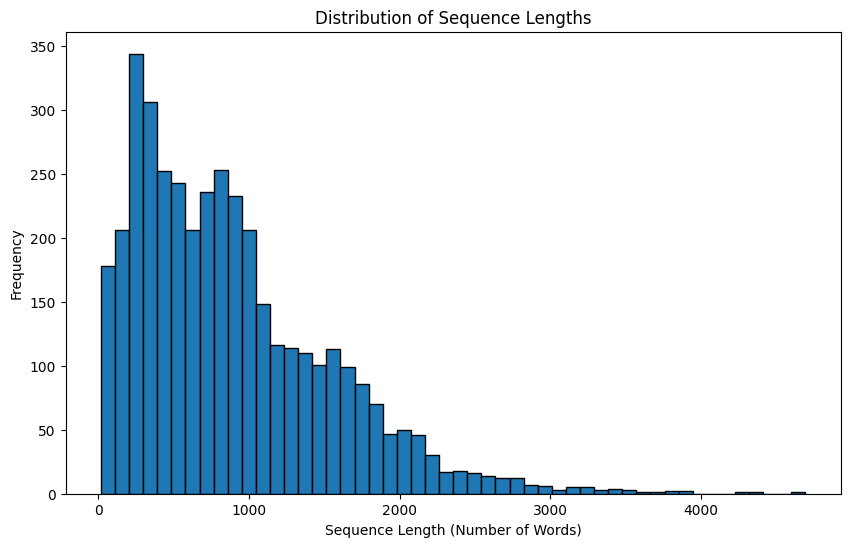

count    3927.000000
mean      888.443341
std       647.271562
min        17.000000
25%       378.500000
50%       764.000000
75%      1247.500000
max      4694.000000
Name: sequence_length, dtype: float64


In [ ]:
data['sequence_length'] = data['Texts'].apply(lambda x: len(x.split()))

# Plot the distribution of sequence lengths
plt.figure(figsize=(10, 6))
plt.hist(data['sequence_length'], bins=50, edgecolor='black')
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length (Number of Words)')
plt.ylabel('Frequency')
plt.show()

# Print summary statistics
print(data['sequence_length'].describe())

In [ ]:
# Define the columns for labels
label_columns = ['Entertainment', 'Healthcare', 'Sports', 'Technology', 'Tourism']

# Initialize empty lists to store the splits
train_data = []
val_data = []
test_data = []

# Iterate over each class (domain)
for label in label_columns:
    # Filter data for the current class
    class_data = data[data[label] == 1]

    # Calculate the split indices
    num_samples = len(class_data)
    train_end = int(0.5 * num_samples)  # First 50% for training
    val_end = train_end + int(0.2 * num_samples)  # Next 20% for validation

    # Split the data
    train_data.append(class_data[:train_end])
    val_data.append(class_data[train_end:val_end])
    test_data.append(class_data[val_end:])

# Concatenate the splits across all classes
train_data = pd.concat(train_data)
val_data = pd.concat(val_data)
test_data = pd.concat(test_data)

# Shuffle the datasets (optional but recommended)
train_data = train_data.sample(frac=1, random_state=42).reset_index(drop=True)
val_data = val_data.sample(frac=1, random_state=42).reset_index(drop=True)
test_data = test_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Extract cleaned_text and labels
texts_train = train_data['Texts'].tolist()
texts_val = val_data['Texts'].tolist()
texts_test = test_data['Texts'].tolist()

# Convert one-hot encoded labels to class indices
labels_train = train_data[label_columns].values
labels_val = val_data[label_columns].values
labels_test = test_data[label_columns].values


# Step 2: Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(preprocessed_texts)

# Convert texts to sequences
sequences_train = tokenizer.texts_to_sequences(texts_train)
sequences_val = tokenizer.texts_to_sequences(texts_val)
sequences_test = tokenizer.texts_to_sequences(texts_test)

# Pad sequences to ensure uniform input size
max_sequence_length = 850
X_train = pad_sequences(sequences_train, maxlen=max_sequence_length)
X_val = pad_sequences(sequences_val, maxlen=max_sequence_length)
X_test = pad_sequences(sequences_test, maxlen=max_sequence_length)

# Step 3: Word2Vec Embeddings
# Train a Word2Vec model (or load a pre-trained one)
sentences = [text.split() for text in preprocessed_texts]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Create embedding matrix
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))  # Bidirectional LSTM
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(label_columns), activation='softmax'))  # Softmax for single-label multi-class classification

C:\Users\Siddhesh\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Step 5: Compile and train the model
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

# Train the model
model.fit(X_train, labels_train, validation_data=(X_val, labels_val), epochs=10, batch_size=32)

# Step 6: Evaluate the model
# Predict probabilities on the validation set
y_pred_probs = model.predict(X_val)

# Get the predicted class (argmax of probabilities)
y_pred = np.argmax(y_pred_probs, axis=1)

Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 22s 326ms/step - accuracy: 0.4769 - auc_6: 0.7887 - loss: 0.4646 - precision_6: 0.6595 - recall_6: 0.2895 - val_accuracy: 0.8978 - val_auc_6: 0.9713 - val_loss: 0.1641 - val_precision_6: 0.9148 - val_recall_6: 0.8914
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 19s 303ms/step - accuracy: 0.9287 - auc_6: 0.9871 - loss: 0.1283 - precision_6: 0.9417 - recall_6: 0.9113 - val_accuracy: 0.9055 - val_auc_6: 0.9888 - val_loss: 0.1012 - val_precision_6: 0.9134 - val_recall_6: 0.9029
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 340ms/step - accuracy: 0.9513 - auc_6: 0.9903 - loss: 0.0823 - precision_6: 0.9586 - recall_6: 0.9457 - val_accuracy: 0.9272 - val_auc_6: 0.9901 - val_loss: 0.0721 - val_precision_6: 0.9328 - val_recall_6: 0.9221
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 322ms/step - accuracy: 0.9727 - auc_6: 0.9932 - loss: 0.0550 - precision_6: 0.9758 - recall_6: 0.9706 - val_accuracy: 0.9374 - val_auc_6: 0.9910 - val_loss: 0.0593 - val_precision_6: 0.9386 - v

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, f1_score

# Step 6: Evaluate the model
# Predict probabilities on the validation set
y_pred_probs = model.predict(X_test)

# Get the predicted class (argmax of probabilities)
y_pred = np.argmax(y_pred_probs, axis=1)
# labels_test = np.argmax(labels_test, axis=1)
# Print classification report
print("Classification Report:")
print(classification_report(labels_test, y_pred, target_names=label_columns))

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step
Classification Report:
               precision    recall  f1-score   support

Entertainment       0.99      0.98      0.99       191
   Healthcare       0.99      0.98      0.98       275
       Sports       0.96      0.84      0.90       103
   Technology       0.96      0.99      0.97       443
      Tourism       1.00      1.00      1.00       169

     accuracy                           0.98      1181
    macro avg       0.98      0.96      0.97      1181
 weighted avg       0.98      0.98      0.98      1181



In [ ]:
# model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 850, 100)       │     8,924,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,302,289 (35.49 MB)

 Trainable params: 125,829 (491.52 KB)

 Non-trainable params: 8,924,800 (34.05 MB)

 Optimizer params: 251,660 (983.05 KB)

# LSTM + CNN

In [ ]:
# LSTM + CNN model architecture
lstm_cnn = Sequential()
lstm_cnn.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
lstm_cnn.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
lstm_cnn.add(MaxPooling1D(pool_size=2))
lstm_cnn.add(Conv1D(filters=64, kernel_size = 3, activation = 'relu'))
lstm_cnn.add(MaxPooling1D(pool_size=2))
lstm_cnn.add(Bidirectional(LSTM(10)))
lstm_cnn.add(Dense(labels.shape[1], activation='softmax'))

# Compile the model
lstm_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])

# Train the model
history = lstm_cnn.fit(X_train, labels_train, epochs=20, batch_size=32, validation_data=(X_val, labels_val))

Epoch 1/20


C:\Users\Siddhesh\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 0.3924 - auc_8: 0.7022 - loss: 0.5559 - precision_8: 0.4315 - recall_8: 0.0026 - val_accuracy: 0.5747 - val_auc_8: 0.8574 - val_loss: 0.4231 - val_precision_8: 1.0000 - val_recall_8: 0.0741
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - accuracy: 0.7547 - auc_8: 0.9196 - loss: 0.3877 - precision_8: 0.8587 - recall_8: 0.1460 - val_accuracy: 0.7088 - val_auc_8: 0.9133 - val_loss: 0.3351 - val_precision_8: 0.8195 - val_recall_8: 0.6437
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - accuracy: 0.8042 - auc_8: 0.9529 - loss: 0.2958 - precision_8: 0.8725 - recall_8: 0.6887 - val_accuracy: 0.8084 - val_auc_8: 0.9555 - val_loss: 0.2598 - val_precision_8: 0.8761 - val_recall_8: 0.7586
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - accuracy: 0.8906 - auc_8: 0.9862 - loss: 0.2154 - precision_8: 0.9321 - recall_8: 0.8500 - val_accuracy: 0.9208 - val_auc_8: 0.9845 - val_loss: 0.1976 - val_precision_8: 0.9729 - val_recall_8: 0

In [ ]:
y_pred = lstm_cnn.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(labels_test, y_pred, target_names=label_columns))

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step
               precision    recall  f1-score   support

Entertainment       1.00      0.99      1.00       191
   Healthcare       1.00      1.00      1.00       275
       Sports       0.99      0.99      0.99       103
   Technology       1.00      1.00      1.00       443
      Tourism       1.00      1.00      1.00       169

     accuracy                           1.00      1181
    macro avg       1.00      1.00      1.00      1181
 weighted avg       1.00      1.00      1.00      1181



In [ ]:
#model summary
lstm_cnn.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 850, 100)       │     8,924,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 848, 128)       │        38,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 424, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 422, 64)        │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 211, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 20)             │         6,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           105 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,132,621 (34.84 MB)

 Trainable params: 69,273 (270.60 KB)

 Non-trainable params: 8,924,800 (34.05 MB)

 Optimizer params: 138,548 (541.21 KB)

# Fasttext

In [2]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 2.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-linux_x86_64.whl size=4313472 sha256=21bb4b47a724e542471bb3eeb513deb2ad627e715daa1ad34baadf603fde0cb8
  Stored in directory: /root/.cache/pip/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3
Successfully built fasttext


In [3]:
import fasttext as ft

In [10]:
# preprocessing the data for fasttext
dataset = pd.read_csv('Dataset-2.csv')
dataset.head()

,Title,Content,Domain
0,A Few Best Men (2011) - IMDb,A Few Best Men 2011 Not Rated 1h 37m IMDb RATI...,Entertainment
1,A Good Day to Die Hard (2013) - IMDb,A Good Day to Die Hard 2013 R 1h 38m IMDb RATI...,Entertainment
2,A Knight's Tale (2001) - IMDb,A Knights Tale 2001 PG13 2h 12m IMDb RATING 70...,Entertainment
3,Abraham Lincoln: Vampire Hunter (2012) - IMDb,Abraham Lincoln Vampire Hunter 2012 R 1h 45m I...,Entertainment
4,After the Sunset (2004) - IMDb,After the Sunset 2004 PG13 1h 37m IMDb RATING ...,Entertainment


In [11]:
dataset['Texts'] = dataset['Title'] +" "+ dataset['Content']
dataset.drop(['Title', 'Content'], axis = 1, inplace = True)

In [12]:
dataset['Texts'] = preprocessed_texts
dataset.head()

,Domain,Texts
0,Entertainment,best men imdb best men rated h imdb rating k r...
1,Entertainment,good day die hard imdb good day die hard r h i...
2,Entertainment,knight tale imdb knight tale pg h imdb rating ...
3,Entertainment,abraham lincoln vampire hunter imdb abraham li...
4,Entertainment,sunset imdb sunset pg h imdb rating k rating r...


In [13]:
dataset['preprocessed_data'] = '__label__' + dataset['Domain'] + ' ' + dataset['Texts']
dataset.head()

,Domain,Texts,preprocessed_data
0,Entertainment,best men imdb best men rated h imdb rating k r...,__label__Entertainment best men imdb best men ...
1,Entertainment,good day die hard imdb good day die hard r h i...,__label__Entertainment good day die hard imdb ...
2,Entertainment,knight tale imdb knight tale pg h imdb rating ...,__label__Entertainment knight tale imdb knight...
3,Entertainment,abraham lincoln vampire hunter imdb abraham li...,__label__Entertainment abraham lincoln vampire...
4,Entertainment,sunset imdb sunset pg h imdb rating k rating r...,__label__Entertainment sunset imdb sunset pg h...


In [16]:
# Split the data into train and test sets
data = dataset['preprocessed_data']
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)
train_data.to_csv('train_data.csv', index=False, header=False)
test_data.to_csv('test_data.csv', index=False, header=False)

In [17]:
fasttext_model = ft.train_supervised(input='train_data.csv', epoch=25, lr=0.1, wordNgrams=3, loss='hs')

In [19]:
#Evaluationg
fasttext_model.test('test_data.csv')

(1179, 0.8948261238337574, 0.8948261238337574)

In [28]:
## Accuracy of the model
acc = 0
for data in test_data:
    label, text = data.split(' ', 1)
    label = label.replace('__label__', '')
    prediction = fasttext_model.predict(text)[0][0]
    prediction = prediction.replace('__label__', '')
    if label == prediction:
        acc += 1
acc /= len(test_data)
print("Accuracy of fasttext model: ",acc)

Accuracy of fasttext model:  0.8948261238337574
